In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
import time
import os
import cv2
import datetime
import tensorflow as tf
import random as rd
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

Using TensorFlow backend.


In [64]:
train_x = None
train_y = None
n_sample = 0

In [2]:
swipe_x1, swipe_y1, swipe_x2, swipe_y2 = 320, 1000, 320, 1000
mistrust = 1

In [3]:
def get_img():
    os.system('adb shell screencap -p /sdcard/1.png')
    os.system('adb pull /sdcard/1.png .')
    img = cv2.imread('1.png')
    img = img[::7,::7,1].reshape(1,183,103,1)
    return img

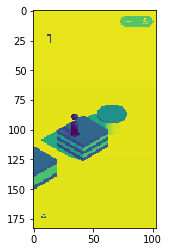

(183, 103, 1)
(183, 103)


In [4]:
img = get_img()
im = plt.imshow(img.reshape(183,103))
plt.show()
input_shape = img.shape[1:]
img_dim = img.shape[1:3]
print(input_shape)
print(img_dim)

In [1]:
input_shape = (183,103,1)

In [5]:
img

array([[[[247],
         [247],
         [247],
         ..., 
         [247],
         [247],
         [247]],

        [[247],
         [247],
         [247],
         ..., 
         [247],
         [247],
         [247]],

        [[247],
         [247],
         [247],
         ..., 
         [247],
         [247],
         [247]],

        ..., 
        [[245],
         [245],
         [245],
         ..., 
         [245],
         [245],
         [245]],

        [[245],
         [245],
         [245],
         ..., 
         [245],
         [245],
         [245]],

        [[245],
         [245],
         [245],
         ..., 
         [245],
         [245],
         [245]]]], dtype=uint8)

In [6]:
np.amax(img[:50,:50])

255

In [5]:
def jump(press_time):
    cmd = 'adb shell input swipe {} {} {} {} {}'.format(swipe_x1, swipe_y1, swipe_x2, swipe_y2, math.ceil(max(press_time,200)))
    os.system(cmd)
    print(press_time)

In [6]:
def success(img_new,img):
    if np.amax(np.absolute(img_new.reshape(img_dim)[:25,:25]-img.reshape(img_dim)[:25,:25]))>50:
        return True
    else:
        return False

In [7]:
def fail(img_new):
    if np.amax(img_new.reshape(img_dim)[:25,:25])>50:
        return False
    else:
        return True

In [10]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adadelta())

In [33]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Nadam())

In [11]:
def network(model,img,confidence):
    if rd.uniform(0,1)<confidence:
        return model.predict(img)
    else:
        return np.array(rd.randint(40,90)).reshape(1,1)

In [12]:
np.array(rd.randint(20,120)).reshape(1,1)[0][0]

69

In [12]:
mistrust = 1

In [6]:
def train(model,img,press_time):
    model.fit(img,np.array([press_time]).reshape(1,1),1)

In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [17]:
def test():
    img = get_img()
    while(True):
        press_time = network(model,img,1)[0][0]
        jump(press_time*10)
        time.sleep(2.3+press_time/200)
        img_new = get_img()
        if fail(img_new):
            jump(2)
            time.sleep(0.8)
            img_new = get_img()
        img = img_new

In [3]:
train_x = np.load("train_x.npy")
train_y = np.load("train_y.npy")
n_sample = train_x.shape[0]

In [ ]:
img = get_img()
while(True):
    mistrust = mistrust*0.99
    press_time = network(model,img,1-mistrust)[0][0]
    jump(press_time*10)
    time.sleep(2.3+press_time/200)
    img_new = get_img()
    if fail(img_new):
        jump(2)
        time.sleep(0.8)
        img_new = get_img()
    elif success(img_new,img):
        if n_sample == 0:
            train_x = img
            train_y = press_time.reshape(1,1)
        else:
            train_x = np.concatenate((train_x,img),axis=0)
            train_y = np.concatenate((train_y,press_time.reshape(1,1)),axis=0)
        n_sample+=1
        if n_sample%128==0:
            mistrust = 1
            print(mistrust)
            model.fit(train_x,train_y)
            np.save('train_x',train_x)
            np.save('train_y',train_y)
    img = img_new

561.977920532
496.441726685
537.21660614
565.479507446
534.708786011
532.336959839
2
534.773406982
2
570.860939026
505.284347534
606.732406616
2
572.868537903
1
Epoch 1/1
2432/2432 [==============================] - 8s 3ms/step - loss: 196.1244
680
670
2
700
490
2
560
590
880
2
600
660
440
2
510
2
650
570
440
2
810
660
2
630
860
2
850
552.56439209
850
2
520
2
591.102867126
870
2
700
450
2
400
2
760
540
2
640
480
604.461021423
2
450
2
570
470
2
595.936660767
600
2
510
2
690
570
810
560
638.537940979
880
2
820
540
626.992263794
2
582.399559021
420
2
510
2
800
554.128303528
2
608.67603302
790
890
880
2
880
670
540
820
2
590
589.078369141
2
569.823608398
549.119529724
2
720
527.97454834
690
582.043609619
2
670
539.744300842
2
573.479537964
670
2
620
535.15171051
589.204139709
602.420310974
790
2
700
567.752952576
2
573.479537964
780
550
500
2
570
516.60774231
490
592.855072021
590
680
2
604.697036743
740
531.304626465
610
586.280784607
2
830
900
2
420
2
568.633575439
622.595214844
2
750
57

2
610.707168579
560.015296936
608.151016235
2
598.312110901
529.471130371
610
2
500
2
599.153747559
840
2
880
599.297027588
633.768959045
2
616.64680481
589.946632385
530.402412415
584.336013794
606.471862793
577.2996521
2
760
571.298522949
2
615.251922607
596.968002319
2
589.164810181
620.721054077
580.526008606
850
2
616.64680481
633.417625427
619.466056824
2
680
582.328529358
583.421592712
595.67199707
2
591.891441345
572.664070129
2
710
542.392959595
460
2
610
553.348846436
830
2
430
2
582.587356567
680
621.097946167
2
595.960159302
556.952667236
760
584.345626831
607.555809021
615.375785828
2
592.961120605
564.504890442
2
770
800
2
595.960159302
579.143371582
548.529815674
611.132354736
599.740486145
609.671630859
2
609.716377258
593.874206543
589.255409241
606.042785645
2
607.87902832
596.609725952
598.359527588
420
2
579.86076355
740
2
618.287124634
564.904251099
592.351417542
606.509017944
619.600982666
613.287506104
586.66557312
581.79599762
2
616.64680481
730
770
2
611.286468

499.926452637
670
2
630
650
583.954048157
602.637138367
565.632209778
562.828330994
575.174713135
2
593.169708252
599.949455261
2
406.693000793
2
602.542037964
522.329483032
569.380950928
2
596.1353302
598.141136169
2
579.227294922
571.376304626
540.315742493
520
850
529.647102356
612.397422791
2
617.572021484
598.441162109
603.700332642
2
586.812477112
573.627548218
548.887481689
552.269210815
2
433.764419556
2
593.615379333
601.284980774
2
750
576.436500549
590.97984314
641.708297729
579.014129639
592.831306458
2
572.780914307
608.88217926
608.92250061
2
610.740585327
510
572.944221497
561.370697021
664.84703064
2
593.148384094
598.855476379
2
582.852630615
574.574699402
2
580.492134094
585.210762024
2
510
2
400
2
603.00907135
860
2
605.83896637
623.94695282
2
610.740585327
596.166687012
2
407.952156067
2
595.802574158
535.886268616
2
570.917243958
1
Epoch 1/1
3328/3328 [==============================] - 10s 3ms/step - loss: 210.8313
760
510
840
420
750
2
641.283416748
830
410
2
630


In [27]:
while(True):
    train(model,img,70)
    print(network(model,img,1))

NameError: name 'img' is not defined

In [17]:
model.save('my_model.h5')

In [ ]:
model.load('my_model.h5')

In [ ]:
network(model,img,1-mistrust)

In [ ]:
jump(math.ceil(400.1123))

In [70]:
np.save('train_x',train_x)
np.save('train_y',train_y)

In [ ]:
train_x.shape

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 181, 101, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 25, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 43, 23, 16)        2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 5, 16)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 5, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25632     
__________

In [ ]:
while True:
    model.fit(train_x,train_y,validation_split=0.2)

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 435us/step - loss: 424.3686 - val_loss: 117.9416
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 220.4241 - val_loss: 149.2517
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 201.1498 - val_loss: 76.8136
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 194.0488 - val_loss: 76.5107
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 193.0797 - val_loss: 130.3919
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 169.6641 - val_loss: 73.0247
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [===========

2764/2764 [==============================] - 1s 328us/step - loss: 136.1949 - val_loss: 76.1483
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 137.0641 - val_loss: 78.7949
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 138.6513 - val_loss: 68.5326
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 134.5429 - val_loss: 69.3851
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 324us/step - loss: 131.3154 - val_loss: 69.0046
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 131.3906 - val_loss: 102.4676
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 136.4392 - val

2764/2764 [==============================] - 1s 336us/step - loss: 122.8335 - val_loss: 63.9054
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 127.8822 - val_loss: 65.5075
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 128.0490 - val_loss: 62.4192
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 127.7804 - val_loss: 71.0120
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 324us/step - loss: 120.6093 - val_loss: 64.7997
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 127.2142 - val_loss: 61.9170
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 123.0560 - val_

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 108.5315 - val_loss: 61.2640
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 111.1120 - val_loss: 64.8507
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 106.1612 - val_loss: 84.0517
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 114.3142 - val_loss: 74.5135
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 107.9744 - val_loss: 72.7939
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 106.0794 - val_loss: 67.1460
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============

2764/2764 [==============================] - 1s 365us/step - loss: 90.2122 - val_loss: 63.4959
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 93.1686 - val_loss: 69.8140
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 85.8624 - val_loss: 67.1324
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 91.6272 - val_loss: 67.6312
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 89.8339 - val_loss: 65.9611
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 94.2075 - val_loss: 64.8207
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 90.0466 - val_loss: 7

2764/2764 [==============================] - 1s 344us/step - loss: 85.8442 - val_loss: 69.8753
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 84.2433 - val_loss: 64.3583
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 79.2514 - val_loss: 76.3145
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 85.4644 - val_loss: 67.4405
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 76.6320 - val_loss: 62.3855
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 80.9321 - val_loss: 65.0342
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 77.8663 - val_loss: 7

2764/2764 [==============================] - 1s 343us/step - loss: 71.2267 - val_loss: 61.9218
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 69.8164 - val_loss: 84.0417
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 348us/step - loss: 73.3126 - val_loss: 71.2669
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 69.0567 - val_loss: 67.7095
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 71.1994 - val_loss: 89.4388
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 70.3762 - val_loss: 73.3858
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 72.4769 - val_loss: 6

2764/2764 [==============================] - 1s 321us/step - loss: 60.6784 - val_loss: 67.5721
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 325us/step - loss: 61.5796 - val_loss: 67.5904
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 62.1088 - val_loss: 68.2672
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 62.3404 - val_loss: 64.8484
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 62.1903 - val_loss: 61.9420
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 58.5923 - val_loss: 59.4419
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 63.9510 - val_loss: 7

2764/2764 [==============================] - 1s 331us/step - loss: 56.7285 - val_loss: 71.9740
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 56.9559 - val_loss: 63.1525
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 55.3723 - val_loss: 71.6334
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 54.9709 - val_loss: 61.3263
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 55.7231 - val_loss: 62.8313
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 55.6244 - val_loss: 67.3650
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 55.7296 - val_loss: 6

2764/2764 [==============================] - 1s 337us/step - loss: 49.3133 - val_loss: 69.3416
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 324us/step - loss: 49.8713 - val_loss: 65.1477
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 49.6644 - val_loss: 64.1352
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 49.7282 - val_loss: 67.0620
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 48.8677 - val_loss: 64.4272
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 47.8479 - val_loss: 66.7348
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 48.6644 - val_loss: 6

2764/2764 [==============================] - 1s 349us/step - loss: 45.8004 - val_loss: 62.5799
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 44.2616 - val_loss: 61.1609
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 44.9587 - val_loss: 62.1585
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 44.1693 - val_loss: 68.6107
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 44.4487 - val_loss: 61.4561
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 335us/step - loss: 42.1669 - val_loss: 68.4404
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 42.2895 - val_loss: 6

2764/2764 [==============================] - 1s 333us/step - loss: 38.9053 - val_loss: 64.4895
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 38.1731 - val_loss: 66.3859
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 326us/step - loss: 37.4780 - val_loss: 67.5497
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 38.7018 - val_loss: 65.7571
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 38.2588 - val_loss: 68.8086
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 37.0757 - val_loss: 62.8972
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 37.1908 - val_loss: 6

2764/2764 [==============================] - 1s 347us/step - loss: 33.3437 - val_loss: 65.8634
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 34.0254 - val_loss: 64.3313
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 33.7280 - val_loss: 62.3751
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 33.0666 - val_loss: 62.0525
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 33.0791 - val_loss: 64.4353
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 324us/step - loss: 34.6758 - val_loss: 63.9956
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 326us/step - loss: 33.3013 - val_loss: 6

2764/2764 [==============================] - 1s 337us/step - loss: 31.8079 - val_loss: 64.1448
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 31.0778 - val_loss: 61.9454
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 366us/step - loss: 31.2674 - val_loss: 64.7371
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 30.8748 - val_loss: 63.0136
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 31.9165 - val_loss: 64.1826
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 326us/step - loss: 31.7312 - val_loss: 64.0636
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 323us/step - loss: 31.1931 - val_loss: 6

2764/2764 [==============================] - 1s 335us/step - loss: 29.8311 - val_loss: 62.0658
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 29.7486 - val_loss: 62.1934
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 29.2290 - val_loss: 65.1534
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 323us/step - loss: 29.5271 - val_loss: 62.8607
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 29.7238 - val_loss: 64.7277
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 28.9066 - val_loss: 64.2659
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 29.1146 - val_loss: 6

2764/2764 [==============================] - 1s 323us/step - loss: 28.1697 - val_loss: 66.2038
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 28.6259 - val_loss: 64.1289
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 27.1885 - val_loss: 65.1417
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 28.1794 - val_loss: 61.7595
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 28.1955 - val_loss: 64.0656
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 28.2429 - val_loss: 62.5980
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 28.3087 - val_loss: 6

2764/2764 [==============================] - 1s 330us/step - loss: 27.6664 - val_loss: 64.1395
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 26.7714 - val_loss: 63.6206
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 27.5408 - val_loss: 62.7135
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 27.6150 - val_loss: 65.5259
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 27.2922 - val_loss: 61.9993
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 324us/step - loss: 27.2602 - val_loss: 62.4205
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 27.4038 - val_loss: 6

2764/2764 [==============================] - 1s 314us/step - loss: 26.7005 - val_loss: 63.3664
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 26.2642 - val_loss: 62.1004
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 25.8365 - val_loss: 65.8561
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 25.8887 - val_loss: 62.7475
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 393us/step - loss: 26.1374 - val_loss: 63.0941
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 394us/step - loss: 25.9718 - val_loss: 62.0563
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 25.6211 - val_loss: 6

2764/2764 [==============================] - 1s 353us/step - loss: 26.2719 - val_loss: 61.1507
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 25.3775 - val_loss: 62.7942
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 407us/step - loss: 25.2761 - val_loss: 65.9300
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 24.8631 - val_loss: 62.9915
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 25.7427 - val_loss: 64.8477
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 27.2271 - val_loss: 64.3837
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 348us/step - loss: 26.0783 - val_loss: 6

2764/2764 [==============================] - 1s 359us/step - loss: 25.2113 - val_loss: 63.5584
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 25.2136 - val_loss: 63.5278
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 24.5421 - val_loss: 64.5078
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 405us/step - loss: 25.0114 - val_loss: 63.6470
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 25.2898 - val_loss: 62.3195
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 24.6281 - val_loss: 63.8554
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 26.3182 - val_loss: 6

2764/2764 [==============================] - 1s 321us/step - loss: 24.1974 - val_loss: 63.3977
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 24.7187 - val_loss: 64.6029
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 24.5608 - val_loss: 64.6523
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 24.4184 - val_loss: 64.3929
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 24.4556 - val_loss: 64.0431
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 24.3594 - val_loss: 65.4716
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 24.4931 - val_loss: 6

2764/2764 [==============================] - 1s 318us/step - loss: 24.0356 - val_loss: 66.7141
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 24.0004 - val_loss: 63.6682
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 24.8990 - val_loss: 64.6933
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 24.1883 - val_loss: 65.6722
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 24.0877 - val_loss: 64.7102
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 24.3765 - val_loss: 65.4888
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 24.7365 - val_loss: 6

2764/2764 [==============================] - 1s 324us/step - loss: 23.7770 - val_loss: 63.0589
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 23.8581 - val_loss: 64.9948
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 319us/step - loss: 23.5197 - val_loss: 63.8130
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 319us/step - loss: 23.5012 - val_loss: 66.2695
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 24.4709 - val_loss: 65.2291
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 23.7814 - val_loss: 64.0194
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 24.0167 - val_loss: 6

2764/2764 [==============================] - 1s 355us/step - loss: 24.2257 - val_loss: 65.4019
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 348us/step - loss: 23.2449 - val_loss: 64.7196
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 23.1893 - val_loss: 64.7622
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 430us/step - loss: 24.4143 - val_loss: 65.5789
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 24.4971 - val_loss: 64.8530
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 389us/step - loss: 24.0873 - val_loss: 65.4326
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 24.4780 - val_loss: 6

Epoch 1/1
2764/2764 [==============================] - 1s 408us/step - loss: 23.7295 - val_loss: 63.8904
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 23.3847 - val_loss: 65.2688
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 23.5501 - val_loss: 64.2961
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 24.1632 - val_loss: 65.2123
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 22.9155 - val_loss: 63.7938
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 430us/step - loss: 23.3888 - val_loss: 65.4478
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 438us/step - loss: 23.9071 - v

2764/2764 [==============================] - 1s 360us/step - loss: 23.4810 - val_loss: 65.1276
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 22.6832 - val_loss: 66.1616
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 24.2768 - val_loss: 66.6209
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 23.5155 - val_loss: 68.2647
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 23.0357 - val_loss: 67.1536
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 415us/step - loss: 23.1890 - val_loss: 65.3484
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 23.8863 - val_loss: 6

2764/2764 [==============================] - 1s 386us/step - loss: 23.1851 - val_loss: 67.4514
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 24.1972 - val_loss: 65.6156
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 22.7305 - val_loss: 65.5015
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 23.0598 - val_loss: 67.7430
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 23.4296 - val_loss: 64.3279
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 22.7405 - val_loss: 66.6694
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 23.1614 - val_loss: 6

2764/2764 [==============================] - 1s 345us/step - loss: 23.2906 - val_loss: 71.3649
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 23.5282 - val_loss: 65.2701
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 22.8263 - val_loss: 65.2343
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 23.2082 - val_loss: 64.3335
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 22.8674 - val_loss: 65.0416
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 22.5648 - val_loss: 62.5109
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 22.7552 - val_loss: 6

2764/2764 [==============================] - 1s 386us/step - loss: 22.8383 - val_loss: 64.9849
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 24.0178 - val_loss: 67.4331
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 23.6730 - val_loss: 67.3695
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 23.4999 - val_loss: 63.3150
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 23.1579 - val_loss: 66.9641
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 415us/step - loss: 22.5576 - val_loss: 64.5184
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 24.1458 - val_loss: 6

2764/2764 [==============================] - 1s 427us/step - loss: 23.0715 - val_loss: 64.5309
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 22.6402 - val_loss: 67.0203
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 23.4239 - val_loss: 65.2662
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 23.0673 - val_loss: 69.4790
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 22.8918 - val_loss: 64.1978
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 23.1349 - val_loss: 63.2850
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 23.3608 - val_loss: 6

2764/2764 [==============================] - 1s 406us/step - loss: 23.6631 - val_loss: 68.4391
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 22.8471 - val_loss: 69.0379
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 386us/step - loss: 22.8423 - val_loss: 69.2759
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 22.8091 - val_loss: 64.8024
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 22.8009 - val_loss: 66.0653
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 391us/step - loss: 22.8207 - val_loss: 68.1663
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 22.8922 - val_loss: 6

2764/2764 [==============================] - 1s 378us/step - loss: 22.8453 - val_loss: 67.8657
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 23.2876 - val_loss: 66.8669
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 407us/step - loss: 22.2910 - val_loss: 66.5907
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 22.7436 - val_loss: 65.2485
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 22.9429 - val_loss: 66.1482
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 23.1112 - val_loss: 66.5331
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 402us/step - loss: 22.2465 - val_loss: 6

2764/2764 [==============================] - 1s 330us/step - loss: 22.9561 - val_loss: 69.3472
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 22.9734 - val_loss: 65.4715
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 22.7183 - val_loss: 67.2086
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 391us/step - loss: 22.7000 - val_loss: 66.3525
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 434us/step - loss: 22.9399 - val_loss: 67.9542
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 22.8214 - val_loss: 65.7093
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 22.7693 - val_loss: 6

2764/2764 [==============================] - 1s 389us/step - loss: 22.2765 - val_loss: 67.8614
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 325us/step - loss: 22.6011 - val_loss: 67.1302
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 320us/step - loss: 22.3048 - val_loss: 64.4720
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 22.6417 - val_loss: 66.8600
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 23.3051 - val_loss: 65.0011
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 22.9623 - val_loss: 67.1129
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 22.7819 - val_loss: 6

2764/2764 [==============================] - 1s 425us/step - loss: 22.2855 - val_loss: 65.2997
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 22.4859 - val_loss: 65.5624
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 22.4141 - val_loss: 67.9385
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 407us/step - loss: 22.0063 - val_loss: 64.8089
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 22.7781 - val_loss: 64.5782
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 23.0323 - val_loss: 64.3103
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 403us/step - loss: 22.7716 - val_loss: 6

2764/2764 [==============================] - 1s 359us/step - loss: 22.4701 - val_loss: 65.6084
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 22.2277 - val_loss: 67.6483
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 23.4917 - val_loss: 63.3260
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 348us/step - loss: 22.0676 - val_loss: 66.7066
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 311us/step - loss: 22.2922 - val_loss: 68.2560
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 456us/step - loss: 22.4173 - val_loss: 64.9165
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 22.5764 - val_loss: 6

2764/2764 [==============================] - 1s 381us/step - loss: 22.6940 - val_loss: 67.0301
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 21.9494 - val_loss: 65.3206
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 22.5691 - val_loss: 65.5160
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 22.2357 - val_loss: 67.3467
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 22.6659 - val_loss: 68.5253
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 22.9156 - val_loss: 66.1781
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 22.3411 - val_loss: 6

2764/2764 [==============================] - 1s 317us/step - loss: 22.7391 - val_loss: 63.9778
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 21.7692 - val_loss: 66.3130
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 403us/step - loss: 21.7239 - val_loss: 65.5184
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 22.1499 - val_loss: 66.4990
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.9370 - val_loss: 67.6001
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 308us/step - loss: 22.1919 - val_loss: 67.7333
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 22.5509 - val_loss: 6

2764/2764 [==============================] - 1s 402us/step - loss: 22.5691 - val_loss: 66.8952
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 22.4422 - val_loss: 64.9761
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 22.4005 - val_loss: 65.9549
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 22.7791 - val_loss: 66.8338
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 22.9445 - val_loss: 65.4336
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 21.9044 - val_loss: 66.0181
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 22.8582 - val_loss: 6

2764/2764 [==============================] - 1s 417us/step - loss: 22.0882 - val_loss: 65.0542
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 22.5576 - val_loss: 68.0466
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 22.9790 - val_loss: 66.6924
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 22.3679 - val_loss: 65.1414
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 428us/step - loss: 22.7930 - val_loss: 67.9550
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 335us/step - loss: 22.3283 - val_loss: 64.9320
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 22.5956 - val_loss: 6

2764/2764 [==============================] - 1s 336us/step - loss: 22.0017 - val_loss: 68.8409
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 22.5149 - val_loss: 65.5116
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 450us/step - loss: 21.9235 - val_loss: 66.6517
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.6472 - val_loss: 65.4003
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 21.8981 - val_loss: 65.7326
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 22.3946 - val_loss: 67.4130
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 22.1222 - val_loss: 6

2764/2764 [==============================] - 1s 316us/step - loss: 22.0546 - val_loss: 69.6791
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 315us/step - loss: 22.6533 - val_loss: 69.6364
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 22.6800 - val_loss: 66.3084
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 22.0769 - val_loss: 69.9109
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 22.0376 - val_loss: 67.5177
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 22.2933 - val_loss: 66.5685
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 318us/step - loss: 22.1988 - val_loss: 6

2764/2764 [==============================] - 1s 362us/step - loss: 21.8317 - val_loss: 62.9436
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 22.2591 - val_loss: 65.1617
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 21.8333 - val_loss: 69.5467
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 22.2467 - val_loss: 66.7254
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.3486 - val_loss: 66.2845
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 22.1767 - val_loss: 67.0585
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 401us/step - loss: 21.9962 - val_loss: 6

2764/2764 [==============================] - 1s 341us/step - loss: 21.9995 - val_loss: 66.4457
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 22.0328 - val_loss: 66.9629
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 423us/step - loss: 22.1254 - val_loss: 69.6435
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 21.8370 - val_loss: 66.8059
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 315us/step - loss: 21.7648 - val_loss: 69.1785
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 425us/step - loss: 22.5788 - val_loss: 67.1886
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 22.7405 - val_loss: 6

2764/2764 [==============================] - 1s 336us/step - loss: 22.2146 - val_loss: 66.6735
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.5042 - val_loss: 68.7240
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 22.2938 - val_loss: 65.9879
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 389us/step - loss: 22.0415 - val_loss: 64.0767
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 299us/step - loss: 21.9618 - val_loss: 64.2766
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.7924 - val_loss: 66.4090
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 426us/step - loss: 21.9948 - val_loss: 6

2764/2764 [==============================] - 1s 324us/step - loss: 22.1329 - val_loss: 67.7229
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 22.2674 - val_loss: 68.6620
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 22.2823 - val_loss: 66.4053
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 415us/step - loss: 22.2591 - val_loss: 66.5124
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 22.7212 - val_loss: 65.3539
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.9885 - val_loss: 66.9530
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 22.2441 - val_loss: 6

2764/2764 [==============================] - 1s 398us/step - loss: 22.3120 - val_loss: 67.7343
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 22.0260 - val_loss: 67.5284
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.2795 - val_loss: 67.9150
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 416us/step - loss: 21.3688 - val_loss: 66.4852
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 402us/step - loss: 21.8534 - val_loss: 67.7644
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.2680 - val_loss: 67.5754
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 21.2067 - val_loss: 6

2764/2764 [==============================] - 1s 340us/step - loss: 21.9348 - val_loss: 66.0596
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 22.3050 - val_loss: 65.4850
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 403us/step - loss: 21.7571 - val_loss: 68.6714
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 22.4482 - val_loss: 67.0241
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 22.0135 - val_loss: 67.8044
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.8605 - val_loss: 66.5322
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.7886 - val_loss: 6

2764/2764 [==============================] - 1s 379us/step - loss: 21.4825 - val_loss: 68.5628
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 22.1116 - val_loss: 65.2988
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 21.6318 - val_loss: 64.7461
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.7043 - val_loss: 65.6540
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 21.5233 - val_loss: 67.4778
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 319us/step - loss: 22.5111 - val_loss: 67.2852
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 21.9710 - val_loss: 6

2764/2764 [==============================] - 1s 316us/step - loss: 22.6583 - val_loss: 65.6281
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 22.0718 - val_loss: 66.4847
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 22.0067 - val_loss: 66.5040
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 21.8512 - val_loss: 68.7864
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 21.8016 - val_loss: 64.9462
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.9403 - val_loss: 65.5788
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.2951 - val_loss: 6

2764/2764 [==============================] - 1s 345us/step - loss: 22.3247 - val_loss: 67.3931
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 319us/step - loss: 22.1794 - val_loss: 66.6439
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 416us/step - loss: 22.4056 - val_loss: 65.2651
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 21.9459 - val_loss: 65.8472
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 21.9027 - val_loss: 66.5032
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 434us/step - loss: 22.0415 - val_loss: 67.2075
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 22.2824 - val_loss: 6

2764/2764 [==============================] - 1s 324us/step - loss: 21.7402 - val_loss: 67.7273
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 22.3395 - val_loss: 66.3266
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 306us/step - loss: 24.6135 - val_loss: 64.8143
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 22.2496 - val_loss: 65.2534
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 442us/step - loss: 21.8604 - val_loss: 68.0387
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 387us/step - loss: 21.5310 - val_loss: 66.7353
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 421us/step - loss: 21.5859 - val_loss: 6

2764/2764 [==============================] - 1s 337us/step - loss: 21.6713 - val_loss: 66.9225
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 413us/step - loss: 22.0001 - val_loss: 67.1740
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 335us/step - loss: 21.8702 - val_loss: 65.2303
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 22.0298 - val_loss: 67.0703
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 22.0237 - val_loss: 68.7418
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 21.6319 - val_loss: 67.5835
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 22.1896 - val_loss: 6

2764/2764 [==============================] - 1s 366us/step - loss: 22.2618 - val_loss: 70.0767
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 411us/step - loss: 22.3718 - val_loss: 67.7615
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 21.7921 - val_loss: 68.8928
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 317us/step - loss: 21.8379 - val_loss: 67.6678
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 20.9714 - val_loss: 67.1536
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.2893 - val_loss: 67.3871
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.7577 - val_loss: 6

2764/2764 [==============================] - 1s 350us/step - loss: 22.5585 - val_loss: 67.8921
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 366us/step - loss: 22.0008 - val_loss: 64.1688
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 21.2754 - val_loss: 66.9659
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 404us/step - loss: 22.8361 - val_loss: 64.8404
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.8154 - val_loss: 66.8280
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 21.4437 - val_loss: 69.6075
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 394us/step - loss: 21.9306 - val_loss: 6

2764/2764 [==============================] - 1s 346us/step - loss: 21.9605 - val_loss: 66.2286
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 22.1744 - val_loss: 65.6528
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 402us/step - loss: 22.1324 - val_loss: 66.9192
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.7917 - val_loss: 67.8787
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 22.4258 - val_loss: 68.4550
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 22.2041 - val_loss: 67.0438
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 22.5063 - val_loss: 6

2764/2764 [==============================] - 1s 397us/step - loss: 22.1387 - val_loss: 67.9121
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 22.0885 - val_loss: 67.3002
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 22.3619 - val_loss: 65.5478
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 21.6125 - val_loss: 66.3732
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 423us/step - loss: 21.6763 - val_loss: 67.3793
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 21.3472 - val_loss: 66.1501
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 324us/step - loss: 21.7345 - val_loss: 6

2764/2764 [==============================] - 1s 376us/step - loss: 21.8191 - val_loss: 69.7405
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.8556 - val_loss: 64.8339
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.6114 - val_loss: 67.1184
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 451us/step - loss: 21.8030 - val_loss: 67.3438
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 22.2782 - val_loss: 68.4571
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 402us/step - loss: 21.7473 - val_loss: 69.8645
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 405us/step - loss: 22.1857 - val_loss: 6

2764/2764 [==============================] - 1s 416us/step - loss: 21.6146 - val_loss: 67.8698
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 22.1403 - val_loss: 66.4393
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 21.4582 - val_loss: 69.5688
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.9267 - val_loss: 68.3511
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.9528 - val_loss: 67.7747
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.6735 - val_loss: 68.0327
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 317us/step - loss: 21.8497 - val_loss: 6

2764/2764 [==============================] - 1s 374us/step - loss: 21.5216 - val_loss: 67.4311
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.5093 - val_loss: 69.8788
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 21.9794 - val_loss: 65.7696
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 393us/step - loss: 22.0410 - val_loss: 70.2822
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 321us/step - loss: 21.8156 - val_loss: 66.7269
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 390us/step - loss: 22.0360 - val_loss: 65.1728
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 458us/step - loss: 21.6469 - val_loss: 6

2764/2764 [==============================] - 1s 356us/step - loss: 21.5482 - val_loss: 71.0988
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 317us/step - loss: 21.4904 - val_loss: 70.2424
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 21.3631 - val_loss: 78.5410
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 21.5101 - val_loss: 73.4105
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 22.1248 - val_loss: 67.2802
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.6454 - val_loss: 66.8713
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 386us/step - loss: 21.5189 - val_loss: 6

2764/2764 [==============================] - 1s 353us/step - loss: 21.9641 - val_loss: 68.5309
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.6144 - val_loss: 69.8721
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 22.7563 - val_loss: 66.9938
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.3844 - val_loss: 68.1589
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 22.1670 - val_loss: 65.2480
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.6998 - val_loss: 67.6386
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 437us/step - loss: 22.4321 - val_loss: 6

2764/2764 [==============================] - 1s 378us/step - loss: 23.0108 - val_loss: 66.2345
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 320us/step - loss: 22.0440 - val_loss: 68.3447
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 401us/step - loss: 21.0248 - val_loss: 65.7391
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 386us/step - loss: 22.5359 - val_loss: 66.1136
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 314us/step - loss: 21.8769 - val_loss: 66.9727
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.6958 - val_loss: 67.9472
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 21.5942 - val_loss: 6

Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 22.0961 - val_loss: 68.3737
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.4749 - val_loss: 71.1955
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 413us/step - loss: 22.0908 - val_loss: 67.4374
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 21.3883 - val_loss: 67.0418
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.3790 - val_loss: 67.1882
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 22.0135 - val_loss: 68.0620
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 425us/step - loss: 22.2353 - v

2764/2764 [==============================] - 1s 425us/step - loss: 21.7784 - val_loss: 71.3631
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 22.2729 - val_loss: 68.4952
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 22.4416 - val_loss: 69.0024
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 430us/step - loss: 22.2625 - val_loss: 67.1409
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 390us/step - loss: 21.2638 - val_loss: 71.9442
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 21.8792 - val_loss: 67.9089
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 22.1928 - val_loss: 6

2764/2764 [==============================] - 1s 316us/step - loss: 22.2880 - val_loss: 66.6578
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 21.5884 - val_loss: 68.5269
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 21.9162 - val_loss: 67.5021
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 21.4435 - val_loss: 70.2327
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 21.9100 - val_loss: 70.9126
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.7929 - val_loss: 68.4961
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 426us/step - loss: 21.9254 - val_loss: 6

2764/2764 [==============================] - 1s 398us/step - loss: 22.6481 - val_loss: 66.4235
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.5283 - val_loss: 66.9728
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 428us/step - loss: 21.7191 - val_loss: 65.0391
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.4699 - val_loss: 66.2723
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 22.1858 - val_loss: 66.9965
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 22.4005 - val_loss: 66.5420
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 437us/step - loss: 22.3093 - val_loss: 6

2764/2764 [==============================] - 1s 341us/step - loss: 22.2643 - val_loss: 65.9030
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 22.0351 - val_loss: 65.8325
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.5267 - val_loss: 66.0615
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 411us/step - loss: 22.0246 - val_loss: 67.7744
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 21.6428 - val_loss: 69.2514
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.6708 - val_loss: 64.5395
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 22.0906 - val_loss: 6

2764/2764 [==============================] - 1s 365us/step - loss: 21.4891 - val_loss: 66.3736
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 22.0256 - val_loss: 66.2706
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.8626 - val_loss: 65.4959
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 22.1925 - val_loss: 66.1452
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 21.6633 - val_loss: 68.9683
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 404us/step - loss: 22.1791 - val_loss: 66.7522
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 22.0380 - val_loss: 6

2764/2764 [==============================] - 1s 388us/step - loss: 21.6913 - val_loss: 66.5792
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 22.0642 - val_loss: 68.3042
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 325us/step - loss: 21.5308 - val_loss: 65.1581
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 21.6683 - val_loss: 67.7387
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 22.6752 - val_loss: 68.5625
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 402us/step - loss: 22.7931 - val_loss: 69.3325
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 22.1417 - val_loss: 6

2764/2764 [==============================] - 1s 387us/step - loss: 21.3511 - val_loss: 65.4467
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.5745 - val_loss: 68.2880
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 21.4616 - val_loss: 68.7901
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.5559 - val_loss: 65.4020
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.2833 - val_loss: 66.3927
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 393us/step - loss: 21.8855 - val_loss: 65.5781
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 22.1994 - val_loss: 6

2764/2764 [==============================] - 1s 346us/step - loss: 21.7901 - val_loss: 66.8869
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 21.4116 - val_loss: 65.0438
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 405us/step - loss: 21.2078 - val_loss: 65.9894
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 21.8296 - val_loss: 67.6254
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 391us/step - loss: 21.5062 - val_loss: 69.3609
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 21.7209 - val_loss: 66.3442
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.2851 - val_loss: 6

2764/2764 [==============================] - 1s 367us/step - loss: 21.7524 - val_loss: 67.9344
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 21.6951 - val_loss: 69.5751
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 21.6243 - val_loss: 65.7824
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 21.4974 - val_loss: 69.8997
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.9250 - val_loss: 68.2088
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 412us/step - loss: 21.6089 - val_loss: 71.1814
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 22.3426 - val_loss: 6

2764/2764 [==============================] - 1s 350us/step - loss: 21.4472 - val_loss: 67.1240
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.6443 - val_loss: 64.7571
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 22.3998 - val_loss: 65.7396
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 22.1403 - val_loss: 65.8008
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.3941 - val_loss: 67.8341
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 21.9723 - val_loss: 64.8441
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 438us/step - loss: 22.3479 - val_loss: 6

2764/2764 [==============================] - 1s 402us/step - loss: 21.5461 - val_loss: 69.9207
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.6687 - val_loss: 68.8033
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.8823 - val_loss: 68.3435
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 412us/step - loss: 21.8477 - val_loss: 67.9412
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.7778 - val_loss: 68.7653
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 421us/step - loss: 21.7306 - val_loss: 67.0762
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.5442 - val_loss: 6

2764/2764 [==============================] - 1s 413us/step - loss: 21.5309 - val_loss: 68.0497
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 21.7206 - val_loss: 69.5007
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.4101 - val_loss: 70.9811
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 21.7022 - val_loss: 67.4706
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 22.0211 - val_loss: 69.3061
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 393us/step - loss: 21.2170 - val_loss: 69.1200
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 21.5610 - val_loss: 6

2764/2764 [==============================] - 1s 357us/step - loss: 22.0803 - val_loss: 68.1511
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 21.5332 - val_loss: 67.1336
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.7535 - val_loss: 72.4461
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 412us/step - loss: 21.7075 - val_loss: 67.2396
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.7697 - val_loss: 67.0419
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 426us/step - loss: 22.5135 - val_loss: 67.8179
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 423us/step - loss: 21.0102 - val_loss: 6

2764/2764 [==============================] - 1s 363us/step - loss: 21.1481 - val_loss: 65.5588
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 21.6643 - val_loss: 67.7756
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 21.5579 - val_loss: 65.7422
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.8115 - val_loss: 63.6573
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 317us/step - loss: 21.4281 - val_loss: 65.1813
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 431us/step - loss: 21.3167 - val_loss: 66.9958
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 21.6236 - val_loss: 6

2764/2764 [==============================] - 1s 377us/step - loss: 20.6016 - val_loss: 68.5729
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 21.9067 - val_loss: 66.2717
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.3557 - val_loss: 67.2153
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 22.0689 - val_loss: 67.5968
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 21.7982 - val_loss: 70.2881
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 21.5962 - val_loss: 67.4475
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.9078 - val_loss: 6

2764/2764 [==============================] - 1s 324us/step - loss: 21.9488 - val_loss: 70.7075
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 409us/step - loss: 21.4454 - val_loss: 67.5480
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 21.9544 - val_loss: 68.9828
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.6514 - val_loss: 68.4287
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 308us/step - loss: 21.8128 - val_loss: 67.0804
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 22.1205 - val_loss: 69.3488
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 391us/step - loss: 21.3151 - val_loss: 6

2764/2764 [==============================] - 1s 380us/step - loss: 21.8225 - val_loss: 68.3541
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 415us/step - loss: 21.7609 - val_loss: 65.1965
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 424us/step - loss: 21.4378 - val_loss: 66.0548
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.3624 - val_loss: 66.3819
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 21.1834 - val_loss: 68.5104
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.2277 - val_loss: 67.2384
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 21.6005 - val_loss: 6

2764/2764 [==============================] - 1s 360us/step - loss: 21.6476 - val_loss: 66.5963
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 437us/step - loss: 21.6388 - val_loss: 65.0204
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 387us/step - loss: 21.7197 - val_loss: 67.4132
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 21.8692 - val_loss: 65.9865
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.4741 - val_loss: 64.9804
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.6071 - val_loss: 66.7655
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 405us/step - loss: 22.0152 - val_loss: 6

2764/2764 [==============================] - 1s 395us/step - loss: 21.6836 - val_loss: 66.6125
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.0478 - val_loss: 64.3421
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.4642 - val_loss: 69.0607
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 21.4136 - val_loss: 65.2639
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 429us/step - loss: 21.7867 - val_loss: 68.8102
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 403us/step - loss: 22.3958 - val_loss: 66.0709
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 22.5789 - val_loss: 6

2764/2764 [==============================] - 1s 414us/step - loss: 21.5427 - val_loss: 70.4547
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 21.1275 - val_loss: 73.9516
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 22.3658 - val_loss: 68.5309
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 424us/step - loss: 21.5494 - val_loss: 66.8761
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 405us/step - loss: 21.8615 - val_loss: 68.0994
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 421us/step - loss: 22.4040 - val_loss: 66.9917
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 401us/step - loss: 21.4011 - val_loss: 6

2764/2764 [==============================] - 1s 362us/step - loss: 21.3953 - val_loss: 66.9094
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 21.6000 - val_loss: 68.4013
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 21.3542 - val_loss: 67.2370
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 21.3615 - val_loss: 68.2768
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 389us/step - loss: 21.9265 - val_loss: 64.9337
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 22.1623 - val_loss: 67.3303
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 21.4929 - val_loss: 6

2764/2764 [==============================] - 1s 316us/step - loss: 21.6413 - val_loss: 66.7548
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 21.3141 - val_loss: 66.5914
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.6006 - val_loss: 66.4196
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.3764 - val_loss: 65.7523
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 21.6888 - val_loss: 67.7580
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.8080 - val_loss: 66.1218
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 22.0924 - val_loss: 6

2764/2764 [==============================] - 1s 338us/step - loss: 21.7522 - val_loss: 63.9570
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.8086 - val_loss: 65.4914
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 20.9085 - val_loss: 67.3517
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 21.8685 - val_loss: 64.1279
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 21.2850 - val_loss: 64.4174
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 417us/step - loss: 22.0814 - val_loss: 64.6959
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.5371 - val_loss: 6

2764/2764 [==============================] - 1s 371us/step - loss: 21.5215 - val_loss: 67.8207
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 324us/step - loss: 22.4311 - val_loss: 69.7089
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.6650 - val_loss: 66.0164
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 22.0996 - val_loss: 66.8082
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 315us/step - loss: 22.5311 - val_loss: 69.8865
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 21.2770 - val_loss: 65.8801
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.3629 - val_loss: 6

2764/2764 [==============================] - 1s 349us/step - loss: 21.7989 - val_loss: 67.3606
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 21.5489 - val_loss: 67.1780
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 22.5432 - val_loss: 72.7095
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 22.0661 - val_loss: 75.1838
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.5599 - val_loss: 67.3584
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 22.1607 - val_loss: 70.0644
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.8198 - val_loss: 6

2764/2764 [==============================] - 1s 330us/step - loss: 22.1709 - val_loss: 67.3560
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 22.4527 - val_loss: 68.3245
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.3110 - val_loss: 68.1929
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 408us/step - loss: 21.9495 - val_loss: 66.2778
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 21.8815 - val_loss: 64.5312
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 21.2004 - val_loss: 67.3367
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 21.7977 - val_loss: 6

2764/2764 [==============================] - 1s 337us/step - loss: 21.3452 - val_loss: 65.7925
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 390us/step - loss: 21.8977 - val_loss: 65.2350
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 21.5258 - val_loss: 69.6172
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 21.8579 - val_loss: 65.6825
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.7259 - val_loss: 67.6726
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.5519 - val_loss: 72.9003
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 22.0011 - val_loss: 6

2764/2764 [==============================] - 1s 380us/step - loss: 21.3587 - val_loss: 69.2514
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 21.6987 - val_loss: 69.9551
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.4600 - val_loss: 70.5038
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 21.5752 - val_loss: 68.8659
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 21.3942 - val_loss: 67.7514
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.0957 - val_loss: 70.2167
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 348us/step - loss: 21.9978 - val_loss: 6

2764/2764 [==============================] - 1s 334us/step - loss: 22.0058 - val_loss: 65.8949
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 320us/step - loss: 21.0525 - val_loss: 69.2896
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.0304 - val_loss: 72.3623
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.8862 - val_loss: 68.6227
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.7743 - val_loss: 66.2378
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 22.0384 - val_loss: 66.2362
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 415us/step - loss: 21.4703 - val_loss: 6

2764/2764 [==============================] - 1s 376us/step - loss: 21.8462 - val_loss: 67.6126
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 401us/step - loss: 22.1212 - val_loss: 70.6804
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 321us/step - loss: 21.1805 - val_loss: 71.2379
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 402us/step - loss: 21.4529 - val_loss: 66.5814
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 21.7847 - val_loss: 66.7690
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.1953 - val_loss: 69.4845
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.7032 - val_loss: 6

2764/2764 [==============================] - 1s 350us/step - loss: 22.1297 - val_loss: 71.7058
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 22.1696 - val_loss: 65.5269
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 22.1478 - val_loss: 67.7385
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 21.6108 - val_loss: 64.6049
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 317us/step - loss: 21.6556 - val_loss: 68.0759
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 323us/step - loss: 20.8205 - val_loss: 64.6429
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 413us/step - loss: 21.6965 - val_loss: 6

2764/2764 [==============================] - 1s 358us/step - loss: 20.9734 - val_loss: 67.0013
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 423us/step - loss: 21.7734 - val_loss: 64.7976
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 387us/step - loss: 21.6913 - val_loss: 63.9798
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 21.1286 - val_loss: 64.0187
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 311us/step - loss: 21.7413 - val_loss: 68.8023
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 421us/step - loss: 22.0014 - val_loss: 63.8972
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 21.4718 - val_loss: 6

2764/2764 [==============================] - 1s 411us/step - loss: 21.6112 - val_loss: 68.0462
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 410us/step - loss: 21.1270 - val_loss: 67.6255
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 22.8806 - val_loss: 64.8096
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.6672 - val_loss: 66.2951
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.5618 - val_loss: 64.3131
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 22.0590 - val_loss: 69.2353
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.7380 - val_loss: 6

2764/2764 [==============================] - 1s 458us/step - loss: 22.1831 - val_loss: 67.2371
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.6301 - val_loss: 68.9170
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 433us/step - loss: 22.3645 - val_loss: 69.7137
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 21.3381 - val_loss: 66.6598
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 416us/step - loss: 21.3552 - val_loss: 68.1982
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 21.6169 - val_loss: 78.2720
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 21.8364 - val_loss: 6

2764/2764 [==============================] - 1s 385us/step - loss: 21.5238 - val_loss: 67.9649
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 424us/step - loss: 22.2623 - val_loss: 66.4521
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 22.2578 - val_loss: 65.0330
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.3895 - val_loss: 68.6303
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 404us/step - loss: 21.4567 - val_loss: 70.3414
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.6945 - val_loss: 66.6217
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 22.9046 - val_loss: 6

2764/2764 [==============================] - 1s 435us/step - loss: 21.6868 - val_loss: 67.1405
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 21.4369 - val_loss: 66.8009
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.2312 - val_loss: 69.3385
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 411us/step - loss: 21.3092 - val_loss: 67.1547
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 21.4519 - val_loss: 64.7124
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 21.2130 - val_loss: 66.6251
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 21.2007 - val_loss: 6

2764/2764 [==============================] - 1s 377us/step - loss: 22.0177 - val_loss: 66.7944
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 22.0064 - val_loss: 67.1554
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 21.7341 - val_loss: 65.5940
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 22.2095 - val_loss: 65.1100
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 21.4277 - val_loss: 66.9444
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 387us/step - loss: 21.9595 - val_loss: 67.6630
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 20.8471 - val_loss: 6

2764/2764 [==============================] - 1s 326us/step - loss: 21.0553 - val_loss: 65.3996
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 413us/step - loss: 21.6159 - val_loss: 66.7271
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.2963 - val_loss: 67.3505
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 21.8889 - val_loss: 68.5200
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 21.5097 - val_loss: 66.5482
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 21.9203 - val_loss: 68.7854
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 20.9966 - val_loss: 6

2764/2764 [==============================] - 1s 365us/step - loss: 22.1037 - val_loss: 64.9426
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 21.4180 - val_loss: 64.4208
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 313us/step - loss: 20.9638 - val_loss: 65.3280
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 425us/step - loss: 21.2666 - val_loss: 69.6854
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.2688 - val_loss: 67.7403
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.2444 - val_loss: 67.9617
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 20.9029 - val_loss: 6

2764/2764 [==============================] - 1s 356us/step - loss: 22.5243 - val_loss: 68.3706
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 22.4455 - val_loss: 66.3571
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 401us/step - loss: 21.5686 - val_loss: 68.1558
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 316us/step - loss: 21.4245 - val_loss: 65.0640
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 21.3055 - val_loss: 66.4097
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.3144 - val_loss: 67.6380
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 22.0338 - val_loss: 6

2764/2764 [==============================] - 1s 386us/step - loss: 21.1927 - val_loss: 68.4157
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 316us/step - loss: 21.9342 - val_loss: 66.0007
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.3236 - val_loss: 64.9687
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 22.3763 - val_loss: 67.0601
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 21.3192 - val_loss: 69.6258
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - ETA: 0s - loss: 21.56 - 1s 421us/step - loss: 21.3907 - val_loss: 71.0526
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - los

2764/2764 [==============================] - 1s 361us/step - loss: 21.8758 - val_loss: 65.5753
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 417us/step - loss: 22.0660 - val_loss: 66.7643
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 422us/step - loss: 21.5444 - val_loss: 64.9717
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 21.7450 - val_loss: 64.8286
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 315us/step - loss: 21.4061 - val_loss: 65.6966
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 21.2473 - val_loss: 65.5387
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 21.1824 - val_loss: 6

2764/2764 [==============================] - 1s 373us/step - loss: 21.4514 - val_loss: 68.1955
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 21.1304 - val_loss: 67.5595
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.8013 - val_loss: 68.6231
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.6439 - val_loss: 67.4796
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.5866 - val_loss: 65.8178
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 20.6256 - val_loss: 65.9985
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 21.7084 - val_loss: 6

2764/2764 [==============================] - 1s 359us/step - loss: 21.5167 - val_loss: 65.0065
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.0899 - val_loss: 69.3007
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 432us/step - loss: 22.1093 - val_loss: 66.3174
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.7751 - val_loss: 66.3555
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 387us/step - loss: 21.5246 - val_loss: 68.8685
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 21.5229 - val_loss: 67.5092
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 403us/step - loss: 21.7373 - val_loss: 7

2764/2764 [==============================] - 1s 415us/step - loss: 21.6739 - val_loss: 65.7490
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 21.6445 - val_loss: 63.5600
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 417us/step - loss: 21.5361 - val_loss: 67.4362
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 22.4757 - val_loss: 65.4460
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 21.8504 - val_loss: 67.0036
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 20.9386 - val_loss: 66.7994
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 22.0501 - val_loss: 6

2764/2764 [==============================] - 1s 320us/step - loss: 21.8640 - val_loss: 67.3568
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 312us/step - loss: 21.3981 - val_loss: 66.9380
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 21.3116 - val_loss: 65.0635
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 21.7708 - val_loss: 67.5385
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 22.1048 - val_loss: 68.8593
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.9686 - val_loss: 68.6224
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 21.6486 - val_loss: 7

2764/2764 [==============================] - 1s 387us/step - loss: 21.7698 - val_loss: 65.3287
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 21.0230 - val_loss: 64.6863
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.3006 - val_loss: 65.4295
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 21.8218 - val_loss: 65.5696
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 489us/step - loss: 21.5074 - val_loss: 66.0639
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 21.7370 - val_loss: 66.6766
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 21.3453 - val_loss: 6

2764/2764 [==============================] - 1s 377us/step - loss: 21.7815 - val_loss: 66.2798
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 21.5929 - val_loss: 64.9487
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 22.3580 - val_loss: 68.7030
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.8236 - val_loss: 73.1890
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 308us/step - loss: 22.1617 - val_loss: 63.1050
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 21.6948 - val_loss: 67.3888
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 421us/step - loss: 21.9655 - val_loss: 7

2764/2764 [==============================] - 1s 366us/step - loss: 21.8850 - val_loss: 64.4625
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 404us/step - loss: 20.8237 - val_loss: 67.7211
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.8177 - val_loss: 66.2249
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.3921 - val_loss: 66.2261
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.5915 - val_loss: 67.6375
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 21.9231 - val_loss: 66.1839
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 319us/step - loss: 22.0391 - val_loss: 6

2764/2764 [==============================] - 1s 339us/step - loss: 21.3403 - val_loss: 65.1945
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 21.1363 - val_loss: 67.8902
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 426us/step - loss: 21.0066 - val_loss: 69.4926
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 22.1117 - val_loss: 65.4194
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 366us/step - loss: 21.4258 - val_loss: 68.3603
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 390us/step - loss: 21.5695 - val_loss: 67.1552
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.1660 - val_loss: 6

2764/2764 [==============================] - 1s 383us/step - loss: 20.8672 - val_loss: 67.1723
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 21.2135 - val_loss: 67.9339
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 21.0181 - val_loss: 65.0788
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 366us/step - loss: 21.8370 - val_loss: 65.5600
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 21.8994 - val_loss: 67.3402
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 20.9040 - val_loss: 62.6291
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 417us/step - loss: 22.3179 - val_loss: 6

2764/2764 [==============================] - 1s 329us/step - loss: 21.8175 - val_loss: 63.5895
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.7432 - val_loss: 64.8904
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 422us/step - loss: 21.4102 - val_loss: 68.0203
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 405us/step - loss: 22.5260 - val_loss: 64.9162
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.4064 - val_loss: 67.5339
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 21.2553 - val_loss: 69.9568
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 21.3061 - val_loss: 6

2764/2764 [==============================] - 1s 368us/step - loss: 21.9420 - val_loss: 64.3307
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.0000 - val_loss: 65.3947
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 20.7933 - val_loss: 66.1233
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 21.3690 - val_loss: 71.6387
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 20.9185 - val_loss: 65.2077
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 20.6495 - val_loss: 66.4609
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 394us/step - loss: 21.7921 - val_loss: 6

2764/2764 [==============================] - 1s 362us/step - loss: 21.7235 - val_loss: 64.3531
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 20.9481 - val_loss: 66.1067
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 21.6523 - val_loss: 70.3670
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.7101 - val_loss: 67.6190
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 436us/step - loss: 21.0563 - val_loss: 66.2057
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 21.1040 - val_loss: 65.0981
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 21.6957 - val_loss: 6

2764/2764 [==============================] - 1s 379us/step - loss: 21.2916 - val_loss: 66.7047
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.5017 - val_loss: 67.0802
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.4371 - val_loss: 68.1001
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 324us/step - loss: 21.3558 - val_loss: 68.8265
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 415us/step - loss: 22.0462 - val_loss: 64.5095
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 435us/step - loss: 20.9089 - val_loss: 65.3677
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 21.4721 - val_loss: 6

2764/2764 [==============================] - 1s 395us/step - loss: 21.2530 - val_loss: 64.4926
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.6354 - val_loss: 67.1829
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 386us/step - loss: 20.7562 - val_loss: 65.5720
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 21.2617 - val_loss: 67.7213
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 308us/step - loss: 21.8309 - val_loss: 66.3662
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.3612 - val_loss: 64.9749
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 22.3315 - val_loss: 6

2764/2764 [==============================] - 1s 402us/step - loss: 21.4740 - val_loss: 62.9178
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 21.8602 - val_loss: 65.4089
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 423us/step - loss: 22.4595 - val_loss: 65.7560
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 423us/step - loss: 21.7227 - val_loss: 66.3971
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.9890 - val_loss: 65.8480
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 22.0515 - val_loss: 64.1688
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 326us/step - loss: 21.7615 - val_loss: 6

2764/2764 [==============================] - 1s 340us/step - loss: 21.9417 - val_loss: 66.1191
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.4361 - val_loss: 65.7169
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 21.9412 - val_loss: 67.3489
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 21.2177 - val_loss: 65.0084
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 438us/step - loss: 21.4379 - val_loss: 67.0809
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.9600 - val_loss: 69.0021
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.3337 - val_loss: 6

2764/2764 [==============================] - 1s 366us/step - loss: 21.8196 - val_loss: 66.0684
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.8397 - val_loss: 65.0611
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 22.1017 - val_loss: 64.4484
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 403us/step - loss: 22.0364 - val_loss: 68.3348
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 422us/step - loss: 22.5161 - val_loss: 66.9333
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.1759 - val_loss: 65.6851
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 22.3159 - val_loss: 6

2764/2764 [==============================] - 1s 359us/step - loss: 21.2705 - val_loss: 65.1809
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 21.2949 - val_loss: 68.5579
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.2738 - val_loss: 68.3598
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 20.7897 - val_loss: 65.9150
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 21.1449 - val_loss: 68.6962
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 21.5217 - val_loss: 66.4986
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 21.0482 - val_loss: 6

2764/2764 [==============================] - 1s 320us/step - loss: 22.2425 - val_loss: 66.5966
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 21.7133 - val_loss: 65.7598
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 430us/step - loss: 21.7459 - val_loss: 68.6693
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 402us/step - loss: 21.4168 - val_loss: 62.3060
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 417us/step - loss: 22.0088 - val_loss: 66.9576
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 21.1952 - val_loss: 62.8272
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.5569 - val_loss: 6

2764/2764 [==============================] - 1s 338us/step - loss: 21.4007 - val_loss: 64.9447
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 335us/step - loss: 22.1416 - val_loss: 64.4884
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.6631 - val_loss: 66.5291
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 431us/step - loss: 21.4763 - val_loss: 63.7104
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 426us/step - loss: 21.6801 - val_loss: 64.8454
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 403us/step - loss: 21.5427 - val_loss: 66.8547
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 21.1099 - val_loss: 6

2764/2764 [==============================] - 1s 377us/step - loss: 21.3185 - val_loss: 64.0481
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 23.3053 - val_loss: 64.3934
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 311us/step - loss: 21.5004 - val_loss: 66.3757
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 22.1541 - val_loss: 65.8419
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.3471 - val_loss: 64.0382
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 312us/step - loss: 21.2940 - val_loss: 66.6851
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 21.8324 - val_loss: 6

2764/2764 [==============================] - 1s 384us/step - loss: 22.1914 - val_loss: 68.7907
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.1813 - val_loss: 66.7950
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.8960 - val_loss: 67.0676
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 326us/step - loss: 21.5872 - val_loss: 64.4803
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 21.7046 - val_loss: 67.8277
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 21.5658 - val_loss: 67.1827
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 21.5971 - val_loss: 6

2764/2764 [==============================] - 1s 339us/step - loss: 21.2216 - val_loss: 68.8637
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.7174 - val_loss: 71.1864
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 320us/step - loss: 20.8945 - val_loss: 72.0234
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.6415 - val_loss: 67.5567
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 22.0756 - val_loss: 70.0310
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.8512 - val_loss: 67.2514
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 335us/step - loss: 21.6263 - val_loss: 6

2764/2764 [==============================] - ETA: 0s - loss: 21.64 - 1s 364us/step - loss: 21.2707 - val_loss: 64.5224
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.5454 - val_loss: 65.2379
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.7435 - val_loss: 64.3280
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 437us/step - loss: 21.1501 - val_loss: 66.7156
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 21.5520 - val_loss: 64.7887
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 21.1761 - val_loss: 65.5070
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - los

2764/2764 [==============================] - 1s 423us/step - loss: 20.8274 - val_loss: 67.5223
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 20.6671 - val_loss: 66.4481
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 421us/step - loss: 20.6042 - val_loss: 67.4842
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 409us/step - loss: 22.3753 - val_loss: 70.9320
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.9340 - val_loss: 70.7387
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 415us/step - loss: 21.6902 - val_loss: 64.5437
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 21.4627 - val_loss: 6

2764/2764 [==============================] - 1s 337us/step - loss: 21.2595 - val_loss: 65.4601
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.7202 - val_loss: 64.9495
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 424us/step - loss: 21.4164 - val_loss: 66.8883
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 20.7998 - val_loss: 67.0247
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 401us/step - loss: 21.8986 - val_loss: 67.2016
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.8376 - val_loss: 66.3842
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 391us/step - loss: 21.6263 - val_loss: 6

2764/2764 [==============================] - 1s 309us/step - loss: 22.2369 - val_loss: 63.8311
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.2558 - val_loss: 63.2255
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.4609 - val_loss: 65.6390
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 433us/step - loss: 21.9645 - val_loss: 66.9257
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 20.7677 - val_loss: 66.9417
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 22.2185 - val_loss: 63.9847
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 21.9604 - val_loss: 6

2764/2764 [==============================] - 1s 371us/step - loss: 21.4698 - val_loss: 70.5554
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 21.4493 - val_loss: 66.1481
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 308us/step - loss: 20.7040 - val_loss: 64.3588
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.5180 - val_loss: 67.2287
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.0004 - val_loss: 67.0018
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 20.8318 - val_loss: 62.6348
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 22.1119 - val_loss: 6

2764/2764 [==============================] - 1s 355us/step - loss: 21.1292 - val_loss: 69.9180
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 21.5252 - val_loss: 66.3608
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 433us/step - loss: 21.5501 - val_loss: 67.4150
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 21.4012 - val_loss: 68.1266
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 21.8342 - val_loss: 66.8437
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 21.9425 - val_loss: 67.9013
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 21.3201 - val_loss: 6

2764/2764 [==============================] - 1s 383us/step - loss: 21.5365 - val_loss: 65.2454
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 22.5476 - val_loss: 65.8306
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.4883 - val_loss: 63.8208
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.4082 - val_loss: 68.1069
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 21.2713 - val_loss: 67.7735
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 21.4815 - val_loss: 66.4266
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 21.2262 - val_loss: 6

2764/2764 [==============================] - 1s 358us/step - loss: 21.3739 - val_loss: 65.9841
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 20.8376 - val_loss: 68.8535
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 22.2392 - val_loss: 70.9863
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.0218 - val_loss: 64.8422
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 20.9113 - val_loss: 65.9411
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 22.7473 - val_loss: 64.0335
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.4745 - val_loss: 6

2764/2764 [==============================] - 1s 332us/step - loss: 21.1813 - val_loss: 65.9899
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.5250 - val_loss: 65.1080
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 390us/step - loss: 21.0862 - val_loss: 63.3360
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 21.2409 - val_loss: 68.8330
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 21.4926 - val_loss: 68.7385
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.4343 - val_loss: 67.6658
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 405us/step - loss: 21.1948 - val_loss: 6

2764/2764 [==============================] - 1s 301us/step - loss: 21.1733 - val_loss: 66.5893
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 21.5690 - val_loss: 66.1247
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 21.4911 - val_loss: 67.4085
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 407us/step - loss: 22.5267 - val_loss: 65.5743
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.2303 - val_loss: 65.3656
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 394us/step - loss: 21.2942 - val_loss: 65.9558
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 21.7028 - val_loss: 6

2764/2764 [==============================] - 1s 359us/step - loss: 21.5590 - val_loss: 65.8609
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 22.2125 - val_loss: 63.8940
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 21.5310 - val_loss: 66.5331
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 22.0148 - val_loss: 67.1044
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 21.7664 - val_loss: 65.0217
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.3902 - val_loss: 64.6872
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 22.1719 - val_loss: 6

2764/2764 [==============================] - 1s 426us/step - loss: 21.0460 - val_loss: 66.4739
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 348us/step - loss: 21.2841 - val_loss: 69.0142
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 393us/step - loss: 21.7666 - val_loss: 66.5185
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 312us/step - loss: 21.6068 - val_loss: 65.1500
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 391us/step - loss: 21.3906 - val_loss: 64.6324
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 21.3444 - val_loss: 68.7114
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 22.1645 - val_loss: 6

2764/2764 [==============================] - 1s 387us/step - loss: 21.8222 - val_loss: 66.9150
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 20.6347 - val_loss: 67.4849
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 416us/step - loss: 21.6586 - val_loss: 68.3635
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 22.3485 - val_loss: 67.7770
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 21.5042 - val_loss: 66.5939
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 21.6229 - val_loss: 66.9561
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 22.1245 - val_loss: 6

2764/2764 [==============================] - 1s 379us/step - loss: 21.2612 - val_loss: 67.5144
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 21.6506 - val_loss: 67.3868
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.3244 - val_loss: 68.1074
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 21.4455 - val_loss: 72.1174
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 21.6254 - val_loss: 68.9778
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 323us/step - loss: 21.6048 - val_loss: 65.2463
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.4053 - val_loss: 6

2764/2764 [==============================] - 1s 366us/step - loss: 21.5471 - val_loss: 67.0591
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 415us/step - loss: 21.2555 - val_loss: 66.9305
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 313us/step - loss: 21.5098 - val_loss: 67.8468
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 21.7879 - val_loss: 68.1348
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.4812 - val_loss: 66.5137
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 22.1023 - val_loss: 67.2758
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.4717 - val_loss: 6

2764/2764 [==============================] - 1s 348us/step - loss: 21.0473 - val_loss: 69.2042
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 413us/step - loss: 22.3771 - val_loss: 61.2508
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 430us/step - loss: 22.2698 - val_loss: 69.3152
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 21.6591 - val_loss: 69.1616
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 21.8576 - val_loss: 63.3025
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 389us/step - loss: 21.6693 - val_loss: 65.4119
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 21.5967 - val_loss: 6

2764/2764 [==============================] - 1s 360us/step - loss: 21.5753 - val_loss: 64.0380
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 22.2927 - val_loss: 62.7883
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 21.4394 - val_loss: 65.6638
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 20.9953 - val_loss: 66.2699
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 21.5741 - val_loss: 65.4531
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 20.9860 - val_loss: 65.6779
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 434us/step - loss: 22.0338 - val_loss: 6

2764/2764 [==============================] - 1s 344us/step - loss: 21.5523 - val_loss: 64.7968
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 405us/step - loss: 21.7603 - val_loss: 65.0539
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 321us/step - loss: 21.9375 - val_loss: 66.1223
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 21.2300 - val_loss: 68.4733
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 20.9604 - val_loss: 64.1440
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 21.5688 - val_loss: 68.7971
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 21.0190 - val_loss: 6

2764/2764 [==============================] - 1s 421us/step - loss: 21.0848 - val_loss: 69.8916
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 21.0479 - val_loss: 67.9761
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 21.3850 - val_loss: 66.6829
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 21.5709 - val_loss: 65.1437
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 22.2533 - val_loss: 68.1169
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 321us/step - loss: 21.0677 - val_loss: 67.8889
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.2227 - val_loss: 6

2764/2764 [==============================] - 1s 351us/step - loss: 21.4778 - val_loss: 70.6066
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 405us/step - loss: 21.0447 - val_loss: 68.1581
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.4208 - val_loss: 68.0737
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 422us/step - loss: 21.8605 - val_loss: 67.3850
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.7839 - val_loss: 65.5600
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.8563 - val_loss: 64.2187
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 22.0319 - val_loss: 6

2764/2764 [==============================] - 1s 339us/step - loss: 21.6063 - val_loss: 63.1401
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 21.2086 - val_loss: 65.2384
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 21.7660 - val_loss: 65.0820
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 21.9262 - val_loss: 66.6078
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 313us/step - loss: 21.3132 - val_loss: 68.5528
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.6242 - val_loss: 66.7161
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 21.3306 - val_loss: 6

2764/2764 [==============================] - 1s 366us/step - loss: 21.8096 - val_loss: 68.0036
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 21.2844 - val_loss: 62.6165
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 21.7043 - val_loss: 67.2422
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 415us/step - loss: 21.0046 - val_loss: 65.3356
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.4327 - val_loss: 65.8970
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.7722 - val_loss: 66.7217
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.0541 - val_loss: 6

2764/2764 [==============================] - 1s 347us/step - loss: 22.1642 - val_loss: 67.2425
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 345us/step - loss: 21.3651 - val_loss: 73.1240
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.0754 - val_loss: 66.6491
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 22.2658 - val_loss: 65.1373
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.7679 - val_loss: 65.8474
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 22.5478 - val_loss: 68.2804
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 22.2928 - val_loss: 6

2764/2764 [==============================] - 1s 420us/step - loss: 21.2033 - val_loss: 67.2627
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 335us/step - loss: 21.1523 - val_loss: 67.6963
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 21.7178 - val_loss: 70.6352
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 20.8152 - val_loss: 70.7367
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 21.2731 - val_loss: 65.5456
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.7716 - val_loss: 69.4298
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 22.1199 - val_loss: 7

2764/2764 [==============================] - 1s 310us/step - loss: 22.2090 - val_loss: 67.9364
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.7977 - val_loss: 64.6929
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 21.5990 - val_loss: 66.4394
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 21.2802 - val_loss: 65.4087
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 21.0442 - val_loss: 70.8781
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.3178 - val_loss: 64.0446
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.9337 - val_loss: 6

2764/2764 [==============================] - 1s 335us/step - loss: 21.3197 - val_loss: 64.1189
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 21.2903 - val_loss: 64.6567
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 319us/step - loss: 21.4334 - val_loss: 64.3190
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 21.7905 - val_loss: 66.5476
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 22.1321 - val_loss: 65.3727
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.0031 - val_loss: 65.6209
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 22.1953 - val_loss: 6

2764/2764 [==============================] - 1s 371us/step - loss: 21.9038 - val_loss: 64.7731
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 20.6416 - val_loss: 67.4316
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.5240 - val_loss: 66.7236
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 319us/step - loss: 21.8309 - val_loss: 69.4432
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 21.0907 - val_loss: 65.4369
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 401us/step - loss: 22.1099 - val_loss: 64.0172
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 20.6501 - val_loss: 6

2764/2764 [==============================] - 1s 364us/step - loss: 21.9401 - val_loss: 68.4567
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 21.2123 - val_loss: 67.1016
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.5768 - val_loss: 67.9686
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 21.5917 - val_loss: 71.1995
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.7692 - val_loss: 65.7644
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 22.1494 - val_loss: 66.7764
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 21.6324 - val_loss: 6

2764/2764 [==============================] - 1s 412us/step - loss: 22.7016 - val_loss: 62.6808
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 21.7054 - val_loss: 69.8215
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.9656 - val_loss: 67.0938
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 21.6695 - val_loss: 67.9415
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 21.6621 - val_loss: 64.9337
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 20.7496 - val_loss: 67.6128
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 22.0564 - val_loss: 6

2764/2764 [==============================] - 1s 382us/step - loss: 21.3692 - val_loss: 64.7822
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 448us/step - loss: 21.1031 - val_loss: 66.7946
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 21.7371 - val_loss: 67.2379
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.1844 - val_loss: 65.7870
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 20.9916 - val_loss: 67.7629
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 20.7923 - val_loss: 63.9985
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.4272 - val_loss: 6

2764/2764 [==============================] - 1s 304us/step - loss: 21.6125 - val_loss: 63.9680
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 20.9871 - val_loss: 67.1799
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 21.1874 - val_loss: 66.0500
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.3279 - val_loss: 63.2653
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.2365 - val_loss: 64.4200
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 20.9203 - val_loss: 67.9487
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 22.1928 - val_loss: 6

2764/2764 [==============================] - 1s 389us/step - loss: 20.9303 - val_loss: 65.5365
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.2084 - val_loss: 65.0202
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 21.4520 - val_loss: 65.1364
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 319us/step - loss: 21.5737 - val_loss: 65.0474
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.1203 - val_loss: 66.5712
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.8581 - val_loss: 67.1748
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 389us/step - loss: 21.9551 - val_loss: 6

2764/2764 [==============================] - 1s 420us/step - loss: 21.8366 - val_loss: 66.6791
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.2906 - val_loss: 67.6166
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.4262 - val_loss: 65.7235
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 21.7978 - val_loss: 66.3079
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 20.9342 - val_loss: 69.4836
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 21.3339 - val_loss: 68.6845
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 20.8621 - val_loss: 6

2764/2764 [==============================] - 1s 328us/step - loss: 20.8308 - val_loss: 65.7753
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 428us/step - loss: 21.1016 - val_loss: 68.4584
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 21.4152 - val_loss: 65.0552
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 409us/step - loss: 21.9550 - val_loss: 66.6270
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 22.9287 - val_loss: 68.7479
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 309us/step - loss: 20.9095 - val_loss: 68.5139
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 20.9760 - val_loss: 6

2764/2764 [==============================] - 1s 353us/step - loss: 20.8722 - val_loss: 65.8042
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 331us/step - loss: 21.5850 - val_loss: 65.5410
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 410us/step - loss: 22.4734 - val_loss: 71.6439
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 425us/step - loss: 21.9395 - val_loss: 62.9998
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.6029 - val_loss: 64.9039
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.8135 - val_loss: 65.2693
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 21.5999 - val_loss: 6

2764/2764 [==============================] - 1s 389us/step - loss: 21.1770 - val_loss: 63.2785
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 21.6726 - val_loss: 64.1542
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 403us/step - loss: 21.3356 - val_loss: 63.6906
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.1087 - val_loss: 64.3142
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 20.4876 - val_loss: 66.2270
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 389us/step - loss: 21.6220 - val_loss: 65.5046
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 387us/step - loss: 21.7986 - val_loss: 6

2764/2764 [==============================] - 1s 348us/step - loss: 21.5896 - val_loss: 67.0782
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.2409 - val_loss: 66.6102
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.7991 - val_loss: 66.4648
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 20.7003 - val_loss: 67.2664
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.4565 - val_loss: 68.0807
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 21.0987 - val_loss: 69.5737
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 21.2533 - val_loss: 6

2764/2764 [==============================] - 1s 392us/step - loss: 21.6483 - val_loss: 70.4227
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 22.6305 - val_loss: 72.7918
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - ETA: 0s - loss: 21.56 - 1s 388us/step - loss: 21.8944 - val_loss: 68.4664
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 433us/step - loss: 21.4841 - val_loss: 64.8874
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 412us/step - loss: 21.3904 - val_loss: 67.5004
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 21.4352 - val_loss: 67.4599
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - los

2764/2764 [==============================] - 1s 343us/step - loss: 21.8272 - val_loss: 66.1036
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.1854 - val_loss: 66.0521
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 20.8970 - val_loss: 65.5300
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 20.6303 - val_loss: 65.6078
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 404us/step - loss: 20.8689 - val_loss: 69.0278
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 20.4714 - val_loss: 64.7572
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 413us/step - loss: 21.1069 - val_loss: 6

2764/2764 [==============================] - 1s 385us/step - loss: 21.5026 - val_loss: 67.9356
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 21.3955 - val_loss: 64.4828
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.3180 - val_loss: 70.0639
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 21.3499 - val_loss: 71.0614
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 315us/step - loss: 21.4006 - val_loss: 71.6859
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 311us/step - loss: 21.4580 - val_loss: 69.8609
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 21.0280 - val_loss: 6

2764/2764 [==============================] - 1s 374us/step - loss: 21.4705 - val_loss: 68.2643
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 22.0962 - val_loss: 72.2871
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 393us/step - loss: 21.3599 - val_loss: 66.4780
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 22.2164 - val_loss: 64.7919
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 21.1970 - val_loss: 65.8672
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 20.8584 - val_loss: 65.6431
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 313us/step - loss: 21.6334 - val_loss: 6

2764/2764 [==============================] - 1s 354us/step - loss: 20.7129 - val_loss: 67.2417
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 20.7252 - val_loss: 64.6178
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 21.7240 - val_loss: 66.6774
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 20.8629 - val_loss: 66.5932
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 21.8125 - val_loss: 66.2846
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 435us/step - loss: 21.5775 - val_loss: 65.7932
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.4049 - val_loss: 6

2764/2764 [==============================] - 1s 331us/step - loss: 21.6716 - val_loss: 70.5287
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 22.1277 - val_loss: 68.2285
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 20.9479 - val_loss: 70.3256
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.2327 - val_loss: 68.1248
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.3563 - val_loss: 66.1753
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.3668 - val_loss: 67.2686
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 20.7999 - val_loss: 6

2764/2764 [==============================] - 1s 328us/step - loss: 22.3259 - val_loss: 69.5398
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 314us/step - loss: 22.0821 - val_loss: 70.1616
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 20.8689 - val_loss: 66.8485
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 21.6877 - val_loss: 66.2791
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.0665 - val_loss: 65.6123
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 20.4581 - val_loss: 69.6686
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 381us/step - loss: 21.1723 - val_loss: 6

2764/2764 [==============================] - 1s 320us/step - loss: 21.0709 - val_loss: 67.0883
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 394us/step - loss: 21.5451 - val_loss: 68.1895
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 312us/step - loss: 21.2194 - val_loss: 65.5692
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 21.4814 - val_loss: 68.3703
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 21.9692 - val_loss: 64.1115
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 21.0888 - val_loss: 67.2716
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 417us/step - loss: 21.0286 - val_loss: 6

2764/2764 [==============================] - 1s 361us/step - loss: 21.1376 - val_loss: 68.3567
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 21.6993 - val_loss: 68.2218
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 21.4980 - val_loss: 66.5173
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 21.6333 - val_loss: 69.8203
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 21.3718 - val_loss: 68.7177
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 21.8417 - val_loss: 64.7786
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 21.0591 - val_loss: 6

2764/2764 [==============================] - 1s 338us/step - loss: 21.8793 - val_loss: 67.9533
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 21.2071 - val_loss: 66.1866
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 413us/step - loss: 21.4990 - val_loss: 65.3276
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 382us/step - loss: 20.9830 - val_loss: 65.6180
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 22.1372 - val_loss: 66.3790
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 22.2064 - val_loss: 69.4503
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 316us/step - loss: 21.2083 - val_loss: 6

2764/2764 [==============================] - 1s 355us/step - loss: 21.4678 - val_loss: 64.3757
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 21.3012 - val_loss: 68.4627
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.5252 - val_loss: 67.4530
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 21.7792 - val_loss: 66.6373
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 326us/step - loss: 21.6059 - val_loss: 65.8404
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 20.5101 - val_loss: 67.7645
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 20.5323 - val_loss: 6

2764/2764 [==============================] - 1s 374us/step - loss: 21.0012 - val_loss: 70.7533
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 21.4628 - val_loss: 67.8051
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 423us/step - loss: 20.9335 - val_loss: 69.4549
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 21.0742 - val_loss: 64.8051
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 21.2649 - val_loss: 64.7468
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 20.8934 - val_loss: 65.5788
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.0039 - val_loss: 6

2764/2764 [==============================] - 1s 371us/step - loss: 21.2063 - val_loss: 68.8453
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 311us/step - loss: 21.8518 - val_loss: 68.5888
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 21.3491 - val_loss: 67.3762
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 408us/step - loss: 20.7392 - val_loss: 65.0090
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 419us/step - loss: 21.5229 - val_loss: 65.9279
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.2183 - val_loss: 66.8806
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 21.4739 - val_loss: 7

2764/2764 [==============================] - 1s 349us/step - loss: 20.9444 - val_loss: 69.4086
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 317us/step - loss: 21.2971 - val_loss: 66.3992
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 403us/step - loss: 21.5067 - val_loss: 66.7639
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 21.3369 - val_loss: 66.3138
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.2730 - val_loss: 66.5446
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 21.3293 - val_loss: 67.2914
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.3658 - val_loss: 6

2764/2764 [==============================] - 1s 436us/step - loss: 20.8850 - val_loss: 64.6986
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 310us/step - loss: 20.8832 - val_loss: 66.7602
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 306us/step - loss: 21.3396 - val_loss: 67.6289
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 21.2305 - val_loss: 66.6539
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 349us/step - loss: 21.0547 - val_loss: 70.8779
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.1924 - val_loss: 67.1308
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 459us/step - loss: 21.2031 - val_loss: 6

2764/2764 [==============================] - 1s 365us/step - loss: 21.5197 - val_loss: 64.4819
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.5851 - val_loss: 66.3321
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 20.5736 - val_loss: 64.1842
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 21.1801 - val_loss: 66.2256
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 416us/step - loss: 20.9673 - val_loss: 65.3779
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 417us/step - loss: 21.3754 - val_loss: 67.0986
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 409us/step - loss: 21.3799 - val_loss: 6

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.4657 - val_loss: 69.4058
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 21.1720 - val_loss: 66.9602
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.2302 - val_loss: 65.9406
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 21.4336 - val_loss: 68.6038
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 323us/step - loss: 21.7301 - val_loss: 69.8230
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 412us/step - loss: 21.3283 - val_loss: 73.5842
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 332us/step - loss: 21.7255 - val_loss: 64.7537
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 386us/step - loss: 21.9452 - val_loss: 67.1061
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 21.6720 - val_loss: 68.7715
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 22.5350 - val_loss: 67.8240
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.8032 - val_loss: 63.8011
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 21.7355 - val_loss: 66.4264
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 21.4513 - val_loss: 70.3369
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.4857 - val_loss: 68.8560
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 389us/step - loss: 21.6284 - val_loss: 70.5821
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 21.4211 - val_loss: 69.8562
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 20.7804 - val_loss: 68.3014
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.2033 - val_loss: 66.2062
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 20.5564 - val_loss: 65.1468
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.7543 - val_loss: 67.6155
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 20.6344 - val_loss: 68.1427
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 20.7189 - val_loss: 65.0520
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.0151 - val_loss: 69.6523
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 21.1414 - val_loss: 71.4792
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 315us/step - loss: 21.4647 - val_loss: 66.5086
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 21.6703 - val_loss: 63.8885
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.3405 - val_loss: 66.3970
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 20.7942 - val_loss: 70.2137
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.4311 - val_loss: 64.2457
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 390us/step - loss: 21.7446 - val_loss: 69.0185
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 20.8596 - val_loss: 64.5303
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 20.8685 - val_loss: 65.2627
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 310us/step - loss: 21.7706 - val_loss: 65.8469
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 326us/step - loss: 21.3006 - val_loss: 64.3013
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 366us/step - loss: 21.0945 - val_loss: 67.6191
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 457us/step - loss: 21.2208 - val_loss: 67.7291
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 404us/step - loss: 20.7750 - val_loss: 66.9581
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 22.4612 - val_loss: 67.3503
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 430us/step - loss: 22.2169 - val_loss: 67.6419
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 339us/step - loss: 21.2796 - val_loss: 67.6049
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 21.2336 - val_loss: 67.1670
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 416us/step - loss: 21.3071 - val_loss: 65.8532
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 387us/step - loss: 21.5262 - val_loss: 70.2049
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.2822 - val_loss: 64.3589
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 21.9963 - val_loss: 66.1604
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.4492 - val_loss: 68.2516
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 20.9762 - val_loss: 65.5300
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 326us/step - loss: 21.6187 - val_loss: 65.6055
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 352us/step - loss: 21.7945 - val_loss: 69.7639
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 21.5882 - val_loss: 64.0803
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.6725 - val_loss: 67.4720
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 404us/step - loss: 21.4142 - val_loss: 70.3733
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.0807 - val_loss: 65.1870
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.2721 - val_loss: 66.2756
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 320us/step - loss: 21.2197 - val_loss: 65.6959
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 389us/step - loss: 21.1295 - val_loss: 70.5073
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.3555 - val_loss: 65.3142
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.5948 - val_loss: 68.3058
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.6577 - val_loss: 67.7049
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 387us/step - loss: 21.2177 - val_loss: 68.5146
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 313us/step - loss: 21.6268 - val_loss: 67.8802
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 20.6828 - val_loss: 64.9129
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 326us/step - loss: 21.0369 - val_loss: 65.5244
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 430us/step - loss: 21.8784 - val_loss: 69.0591
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 436us/step - loss: 21.1359 - val_loss: 70.7745
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 20.8392 - val_loss: 69.6366
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 21.7149 - val_loss: 67.0919
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 318us/step - loss: 21.0461 - val_loss: 69.1043
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.5238 - val_loss: 66.7988
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.3044 - val_loss: 64.2971
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 458us/step - loss: 21.3247 - val_loss: 66.7078
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 410us/step - loss: 21.3848 - val_loss: 69.6026
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 20.6201 - val_loss: 67.7543
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 355us/step - loss: 21.6175 - val_loss: 69.2187
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 312us/step - loss: 21.6326 - val_loss: 67.7994
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.4082 - val_loss: 69.5208
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 21.2888 - val_loss: 65.8384
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 393us/step - loss: 21.5045 - val_loss: 66.4818
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 21.0862 - val_loss: 65.7927
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 413us/step - loss: 20.8388 - val_loss: 65.7581
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 425us/step - loss: 21.7534 - val_loss: 66.0735
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 313us/step - loss: 21.2713 - val_loss: 66.0313
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 328us/step - loss: 20.9378 - val_loss: 67.3023
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.9152 - val_loss: 69.8350
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 414us/step - loss: 21.1334 - val_loss: 66.1231
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.0132 - val_loss: 74.1936
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.1044 - val_loss: 66.8789
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.5512 - val_loss: 68.2104
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.1940 - val_loss: 69.1407
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 336us/step - loss: 21.2142 - val_loss: 67.7560
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [====================

2764/2764 [==============================] - 1s 363us/step - loss: 21.6754 - val_loss: 68.5764
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 22.0904 - val_loss: 72.1808
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 404us/step - loss: 21.9544 - val_loss: 66.7947
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.2742 - val_loss: 68.3127
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 21.8476 - val_loss: 69.3879
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 436us/step - loss: 21.1763 - val_loss: 66.4509
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 21.2053 - val_loss: 6

2764/2764 [==============================] - 1s 363us/step - loss: 21.9499 - val_loss: 69.2875
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 21.7244 - val_loss: 67.9889
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 20.8912 - val_loss: 69.4153
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.5269 - val_loss: 64.7608
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 20.8955 - val_loss: 66.9325
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.4283 - val_loss: 65.8339
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.7212 - val_loss: 6

2764/2764 [==============================] - 1s 308us/step - loss: 21.9662 - val_loss: 68.2159
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 20.8436 - val_loss: 72.3632
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 379us/step - loss: 21.5132 - val_loss: 69.7602
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 21.9649 - val_loss: 70.1471
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 373us/step - loss: 21.2023 - val_loss: 67.4034
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 21.2164 - val_loss: 66.6748
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 21.4481 - val_loss: 6

2764/2764 [==============================] - 1s 363us/step - loss: 21.2476 - val_loss: 67.7975
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 395us/step - loss: 21.3008 - val_loss: 66.9394
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 327us/step - loss: 21.8054 - val_loss: 66.1851
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 20.9180 - val_loss: 67.6099
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 21.5092 - val_loss: 68.7061
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 356us/step - loss: 21.1559 - val_loss: 67.0565
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 20.9346 - val_loss: 6

2764/2764 [==============================] - 1s 370us/step - loss: 21.1526 - val_loss: 69.3670
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 21.4181 - val_loss: 67.9745
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 344us/step - loss: 21.2383 - val_loss: 68.5157
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 20.7950 - val_loss: 66.5995
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.5616 - val_loss: 69.2541
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 312us/step - loss: 21.3674 - val_loss: 70.4387
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 316us/step - loss: 20.6508 - val_loss: 6

2764/2764 [==============================] - 1s 376us/step - loss: 21.1409 - val_loss: 66.0312
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 407us/step - loss: 21.6701 - val_loss: 65.3495
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 21.9956 - val_loss: 69.3995
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 340us/step - loss: 22.4080 - val_loss: 66.1043
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 21.3971 - val_loss: 63.6626
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 401us/step - loss: 21.5397 - val_loss: 67.0733
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 305us/step - loss: 21.8247 - val_loss: 6

2764/2764 [==============================] - 1s 383us/step - loss: 20.9598 - val_loss: 68.3323
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 353us/step - loss: 20.7938 - val_loss: 66.9755
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 401us/step - loss: 21.6112 - val_loss: 66.6088
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 20.6002 - val_loss: 66.4655
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 364us/step - loss: 21.8029 - val_loss: 68.3297
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 20.8915 - val_loss: 67.8779
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 20.5789 - val_loss: 6

2764/2764 [==============================] - 1s 337us/step - loss: 21.5293 - val_loss: 67.4788
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 21.3640 - val_loss: 65.0218
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 20.3899 - val_loss: 71.7956
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 20.9275 - val_loss: 70.0051
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 21.2894 - val_loss: 71.6647
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 338us/step - loss: 21.2938 - val_loss: 65.4441
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 392us/step - loss: 21.2435 - val_loss: 6

2764/2764 [==============================] - 1s 421us/step - loss: 21.2981 - val_loss: 67.5422
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 329us/step - loss: 20.6161 - val_loss: 67.2587
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 318us/step - loss: 21.2412 - val_loss: 63.6660
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 419us/step - loss: 20.6680 - val_loss: 65.6581
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 394us/step - loss: 21.6180 - val_loss: 68.7778
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 20.7558 - val_loss: 69.6471
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 21.6073 - val_loss: 6

2764/2764 [==============================] - 1s 374us/step - loss: 21.1859 - val_loss: 65.3669
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 354us/step - loss: 21.9723 - val_loss: 65.6786
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 22.2079 - val_loss: 65.5094
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 337us/step - loss: 22.2382 - val_loss: 72.2841
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 387us/step - loss: 21.1010 - val_loss: 70.2989
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 365us/step - loss: 21.6786 - val_loss: 67.1988
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 21.2868 - val_loss: 6

2764/2764 [==============================] - 1s 366us/step - loss: 20.8839 - val_loss: 68.4042
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 416us/step - loss: 20.4288 - val_loss: 68.6241
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 20.6619 - val_loss: 70.8416
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 20.6301 - val_loss: 71.4214
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 314us/step - loss: 21.1212 - val_loss: 70.6487
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 316us/step - loss: 21.4039 - val_loss: 74.8839
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 21.8148 - val_loss: 6

2764/2764 [==============================] - 1s 373us/step - loss: 20.3560 - val_loss: 72.9301
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.8212 - val_loss: 70.6993
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 21.3650 - val_loss: 71.2512
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 413us/step - loss: 20.8975 - val_loss: 69.1508
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.5352 - val_loss: 66.9424
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 21.3337 - val_loss: 68.0118
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 20.7195 - val_loss: 6

2764/2764 [==============================] - 1s 413us/step - loss: 22.0318 - val_loss: 66.6562
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 342us/step - loss: 21.6057 - val_loss: 68.8688
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 351us/step - loss: 21.4071 - val_loss: 68.2944
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 21.1305 - val_loss: 71.8718
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 391us/step - loss: 21.5660 - val_loss: 70.3890
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 383us/step - loss: 21.7924 - val_loss: 69.3323
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.3325 - val_loss: 6

2764/2764 [==============================] - 1s 391us/step - loss: 22.2230 - val_loss: 64.8277
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 436us/step - loss: 21.2311 - val_loss: 69.5992
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 350us/step - loss: 21.7878 - val_loss: 65.3769
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 393us/step - loss: 21.1836 - val_loss: 66.7291
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 370us/step - loss: 23.3422 - val_loss: 65.4592
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 22.6349 - val_loss: 67.8227
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.1668 - val_loss: 6

2764/2764 [==============================] - 1s 355us/step - loss: 22.2008 - val_loss: 65.1921
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.5190 - val_loss: 69.1933
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 21.2798 - val_loss: 64.8929
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 21.5655 - val_loss: 63.1317
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 21.5403 - val_loss: 64.9730
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 21.0102 - val_loss: 64.7712
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 20.9413 - val_loss: 6

2764/2764 [==============================] - 1s 335us/step - loss: 21.7800 - val_loss: 67.3342
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.7175 - val_loss: 67.9046
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 357us/step - loss: 21.3288 - val_loss: 64.9680
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 362us/step - loss: 21.0292 - val_loss: 67.2395
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 371us/step - loss: 21.0180 - val_loss: 67.7036
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 425us/step - loss: 21.1893 - val_loss: 65.0295
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.7345 - val_loss: 6

2764/2764 [==============================] - 1s 370us/step - loss: 22.3915 - val_loss: 64.7963
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 321us/step - loss: 22.3921 - val_loss: 64.8247
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 320us/step - loss: 21.0790 - val_loss: 67.0191
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 438us/step - loss: 21.2156 - val_loss: 67.2465
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 384us/step - loss: 21.0478 - val_loss: 66.0147
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 343us/step - loss: 22.1201 - val_loss: 67.9559
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 391us/step - loss: 21.8235 - val_loss: 6

2764/2764 [==============================] - 1s 374us/step - loss: 20.5429 - val_loss: 67.9065
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 443us/step - loss: 21.4683 - val_loss: 64.9167
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.7096 - val_loss: 66.1988
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 359us/step - loss: 23.3079 - val_loss: 68.5627
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 21.7909 - val_loss: 67.7970
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 348us/step - loss: 21.5269 - val_loss: 66.9749
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.6737 - val_loss: 6

2764/2764 [==============================] - 1s 393us/step - loss: 21.6089 - val_loss: 66.9020
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 367us/step - loss: 21.7367 - val_loss: 64.8971
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 429us/step - loss: 22.1482 - val_loss: 69.8144
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 412us/step - loss: 21.6248 - val_loss: 72.1317
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.6173 - val_loss: 68.6330
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 372us/step - loss: 21.2526 - val_loss: 69.3397
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 323us/step - loss: 21.3767 - val_loss: 7

2764/2764 [==============================] - 1s 366us/step - loss: 23.2890 - val_loss: 68.3748
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 397us/step - loss: 21.1121 - val_loss: 69.4975
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 22.0483 - val_loss: 70.6336
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 21.6502 - val_loss: 69.9647
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 377us/step - loss: 21.3863 - val_loss: 65.4850
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 22.0686 - val_loss: 66.6365
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.2210 - val_loss: 6

2764/2764 [==============================] - 1s 337us/step - loss: 21.1444 - val_loss: 65.9500
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 447us/step - loss: 21.2711 - val_loss: 66.9340
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 400us/step - loss: 21.4329 - val_loss: 69.0751
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 21.6253 - val_loss: 67.6377
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 325us/step - loss: 21.9421 - val_loss: 72.1061
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 321us/step - loss: 20.8822 - val_loss: 69.7278
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 361us/step - loss: 21.7016 - val_loss: 6

2764/2764 [==============================] - 1s 435us/step - loss: 21.0024 - val_loss: 65.1389
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 323us/step - loss: 21.0501 - val_loss: 68.8927
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 319us/step - loss: 21.3761 - val_loss: 78.7782
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 385us/step - loss: 21.7192 - val_loss: 65.0004
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 378us/step - loss: 20.4819 - val_loss: 67.9969
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 390us/step - loss: 20.8853 - val_loss: 65.9941
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 334us/step - loss: 21.3217 - val_loss: 6

2764/2764 [==============================] - 1s 377us/step - loss: 21.1728 - val_loss: 66.1306
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 347us/step - loss: 21.3643 - val_loss: 68.5694
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 341us/step - loss: 21.0544 - val_loss: 69.1732
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 333us/step - loss: 21.8425 - val_loss: 66.2039
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 21.3000 - val_loss: 64.2184
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 398us/step - loss: 21.0512 - val_loss: 70.1190
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 375us/step - loss: 21.3556 - val_loss: 6

2764/2764 [==============================] - 1s 331us/step - loss: 21.8364 - val_loss: 67.3085
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 419us/step - loss: 20.7525 - val_loss: 70.4281
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 368us/step - loss: 21.1987 - val_loss: 66.5534
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 363us/step - loss: 21.2737 - val_loss: 66.4149
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.1534 - val_loss: 68.2623
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 388us/step - loss: 21.0099 - val_loss: 71.8583
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 348us/step - loss: 21.1964 - val_loss: 6

2764/2764 [==============================] - 1s 341us/step - loss: 21.1108 - val_loss: 68.1778
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 420us/step - loss: 21.0790 - val_loss: 64.5015
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 376us/step - loss: 21.0819 - val_loss: 64.1892
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 358us/step - loss: 21.8625 - val_loss: 66.2190
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 22.0307 - val_loss: 63.4072
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 390us/step - loss: 20.6983 - val_loss: 67.8203
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 330us/step - loss: 20.9690 - val_loss: 6

2764/2764 [==============================] - 1s 334us/step - loss: 21.6990 - val_loss: 64.3906
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 369us/step - loss: 21.2830 - val_loss: 66.8518
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 418us/step - loss: 21.5336 - val_loss: 64.7293
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 380us/step - loss: 20.8944 - val_loss: 68.5507
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 406us/step - loss: 21.3486 - val_loss: 68.2610
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 450us/step - loss: 20.9989 - val_loss: 70.9533
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 396us/step - loss: 21.0189 - val_loss: 6

2764/2764 [==============================] - 1s 310us/step - loss: 20.8624 - val_loss: 71.9952
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 322us/step - loss: 21.0142 - val_loss: 70.5113
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 360us/step - loss: 21.2583 - val_loss: 69.5206
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 346us/step - loss: 21.2713 - val_loss: 70.6348
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 390us/step - loss: 21.7713 - val_loss: 63.1767
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 374us/step - loss: 22.0550 - val_loss: 65.4221
Train on 2764 samples, validate on 692 samples
Epoch 1/1
2764/2764 [==============================] - 1s 399us/step - loss: 21.4293 - val_loss: 6

In [100]:
test()

679.069519043
644.972381592
604.736824036
666.200332642
2
636.189956665
606.906585693
580.840530396
2
646.739807129
547.72026062
644.138031006
628.647689819
589.686126709
573.268661499
622.477416992
2
656.226501465
684.249343872
2
638.997917175
576.546325684
622.89226532
613.993263245
2
641.936187744
615.985946655
701.667022705
2
650.136413574
631.121444702
643.49105835
607.932510376
619.295043945
2
643.857574463
558.6277771
594.150085449
640.268096924
2
602.979125977


KeyboardInterrupt: 

In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam())

In [23]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Conv2D(4, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam())